# 予定
1. アクチュエータへの入力で一旦SB3で学習してみる
2. 逆運動学を利用して、エンドエフェクタの位置あるいは速度などで制御できるようにする
    - 実機でもしっかり取得できる情報じゃないと困る


In [3]:
%matplotlib inline
import os
import mujoco
import numpy as np
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium.spaces import Box
from typing import Dict, Union
import matplotlib.pyplot as plt
import cv2
from typing import Optional, Union

register(
    id='myenv-v0',
    entry_point='myenv.env:MyEnv'
)


DEFAULT_CAMERA_CONFIG = {
    "trackbodyid": -1,
    "distance": 4.0,
}

class MyRobotEnv(MujocoEnv):
    def __init__(
        self, 
        array=None,
        xml_path = "/workspace/ros2_ws/src/RL-hockey/assets/main.xml",
        frame_skip: int = 5,
        default_camera_config: Dict[str, Union[float, int]] = DEFAULT_CAMERA_CONFIG,
        **kwargs,
    ):
        # 一度モデルを読み込んで観測次元を取得
        model = mujoco.MjModel.from_xml_path(xml_path)
        obs_dim = model.nq + model.nv
        observation_space = Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        # 行動空間：joint velocities [-1, 1] 正規化
        # 現状はmodelのアクチュエータが認識していないので、model.nuがなくなっている
        # そのため, model.ctrlもないのでstepができない状態
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=model.actuator_actnum.shape, dtype=np.float32
        )
        self.array = array
        
        # 親クラスの初期化
        super().__init__(
            model_path=xml_path,
            frame_skip=frame_skip,
            observation_space=observation_space,
            render_mode="rgb_array",
            default_camera_config=default_camera_config,
            **kwargs,
        )
        
        self.metadata = {
            "render_modes": [
                "human",
                "rgb_array",
                "depth_array",
                "rgbd_tuple",
            ],
            "render_fps": int(np.round(1.0 / self.dt)),
        }
        

    def step(self, action):
        # 正規化されたactionをスケーリング
        #scaled_action = action * self.model.actuator_ctrlrange[:, 1]
        self.do_simulation(action, self.frame_skip)

        obs = self._get_obs()
        reward = self._compute_reward(obs, action)
        done = False
        info = {}

        return obs, reward, done, info

    def _get_obs(self):
        return np.concatenate([self.data.qpos.flat, self.data.qvel.flat])

    def _compute_reward(self, obs, action):
        # エンドエフェクタの位置を使用した報酬例
        site_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_SITE, "ee_site")
        end_effector_pos = self.data.site_xpos[site_id]
        goal = np.array([0.5, 0.0, 0.2])
        dist = np.linalg.norm(end_effector_pos - goal)
        return -dist

    def reset_model(self):
        # ランダム初期化
        qpos = self.array
        
        qvel = self.init_qvel
        self.set_state(qpos, qvel)
        return self._get_obs()

register(
    id='ArmHockey-v0',
    entry_point='myenv.env:MyEnv'
)

In [4]:
def render(images):
    for img in images:
        # 画像をuint8のBGRに変換（OpenCV用）
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        cv2.imshow('Video', img_bgr)
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

In [137]:
def print_joint(model):
    for i in range(model.njnt):
        name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_JOINT, i)
        addr = model.jnt_qposadr[i]
        dof = model.jnt_dofadr[i]
        type_ = model.jnt_type[i]
        print(f"Joint {i}: name={name}, qpos address={addr}, dof address={dof}, type={type_}")

print_joint(env.model)

Joint 0: name=puck_x, qpos address=0, dof address=0, type=2
Joint 1: name=puck_y, qpos address=1, dof address=1, type=2
Joint 2: name=puck_yaw, qpos address=2, dof address=2, type=3
Joint 3: name=crane_x7_shoulder_fixed_part_pan_joint, qpos address=3, dof address=3, type=3
Joint 4: name=crane_x7_shoulder_revolute_part_tilt_joint, qpos address=4, dof address=4, type=3
Joint 5: name=crane_x7_upper_arm_revolute_part_twist_joint, qpos address=5, dof address=5, type=3
Joint 6: name=crane_x7_upper_arm_revolute_part_rotate_joint, qpos address=6, dof address=6, type=3
Joint 7: name=crane_x7_lower_arm_fixed_part_joint, qpos address=7, dof address=7, type=3
Joint 8: name=crane_x7_lower_arm_revolute_part_joint, qpos address=8, dof address=8, type=3
Joint 9: name=crane_x7_wrist_joint, qpos address=9, dof address=9, type=3
Joint 10: name=crane_x7_gripper_finger_a_joint, qpos address=10, dof address=10, type=3
Joint 11: name=crane_x7_gripper_finger_b_joint, qpos address=11, dof address=11, type=3


In [5]:
def calculate_ik_target_velocities_wdls( # 関数名を変更または引数追加
    model, data,
    target_pos_world: np.ndarray,
    target_orientation_matrix_world: np.ndarray,
    ee_site_id: int,
    ee_body_id: int,
    arm_dof_qvel_indices: np.ndarray, 
    wrist_joint_qvel_indices_in_nv: np.ndarray, # !!! 新規: qvel全体での手首関節のインデックス !!!
    wrist_weight_factor: float, # !!! 新規: 手首の重み係数 (例: 5.0) !!!
    Kp_pos: float, Kd_pos: float,
    Kp_ori: float, Kd_ori: float,
    lambda_ik: float,
    max_joint_velocity: float = 2.0
) -> np.ndarray:
    mujoco.mj_forward(model, data) 

    current_ee_pos = data.site_xpos[ee_site_id]
    current_ee_orientation_matrix = data.site_xmat[ee_site_id].reshape(3, 3)

    J_pos_site = np.zeros((3, model.nv))
    mujoco.mj_jacSite(model, data, J_pos_site, None, ee_site_id)
    J_rot_body = np.zeros((3, model.nv))
    mujoco.mj_jacBody(model, data, None, J_rot_body, ee_body_id)
    J_full = np.vstack([J_pos_site, J_rot_body])

    current_ee_linear_vel = J_pos_site @ data.qvel[:model.nv]
    current_ee_angular_vel = J_rot_body @ data.qvel[:model.nv]

    pos_error = target_pos_world - current_ee_pos
    target_ee_linear_vel_world = np.zeros(3) 
    command_linear_vel = target_ee_linear_vel_world + Kp_pos * pos_error - Kd_pos * current_ee_linear_vel

    target_quat_arr = np.empty(4)
    mujoco.mju_mat2Quat(target_quat_arr, target_orientation_matrix_world.flatten())
    current_quat_arr = np.empty(4)
    mujoco.mju_mat2Quat(current_quat_arr, current_ee_orientation_matrix.flatten())
    conj_current_quat_arr = current_quat_arr.copy() 
    conj_current_quat_arr[1:] *= -1.0
    error_quat_arr = np.empty(4)
    mujoco.mju_mulQuat(error_quat_arr, target_quat_arr, conj_current_quat_arr)
    error_orientation_vec = np.empty(3)
    mujoco.mju_quat2Vel(error_orientation_vec, error_quat_arr, 1.0)
    target_ee_angular_vel_world = np.zeros(3)
    command_angular_vel = target_ee_angular_vel_world + Kp_ori * error_orientation_vec - Kd_ori * current_ee_angular_vel
    task_space_desired_vel = np.concatenate([command_linear_vel, command_angular_vel])

    # --- WDLSのための重み行列設定 ---
    W_inv = np.eye(model.nv) # まずは単位行列で初期化 (全関節の重みは同じ)
    if wrist_joint_qvel_indices_in_nv.size > 0 : # 手首のインデックスが指定されていれば
        W_inv[wrist_joint_qvel_indices_in_nv, wrist_joint_qvel_indices_in_nv] = wrist_weight_factor
    # ---------------------------------

    try:
        J_full_transpose = J_full.T
        # WDLSの計算式
        A_matrix_wdls = J_full @ W_inv @ J_full_transpose + (lambda_ik**2) * np.eye(J_full.shape[0])
        solution_in_task_space_wdls = np.linalg.lstsq(A_matrix_wdls, task_space_desired_vel, rcond=None)[0]
        qvel_des_all_dof = W_inv @ J_full_transpose @ solution_in_task_space_wdls # 重みを適用
    except np.linalg.LinAlgError:
        print(f"IK Warning: Jacobian inversion failed. Setting qvel_des to zero.")
        qvel_des_all_dof = np.zeros(model.nv)

    target_arm_joint_velocities_unclipped = qvel_des_all_dof[arm_dof_qvel_indices]
    target_arm_joint_velocities_clipped = np.clip(
        target_arm_joint_velocities_unclipped,
        -max_joint_velocity,
        max_joint_velocity
    )
    return target_arm_joint_velocities_clipped

Target EE Position: [-0.9  0.2  0.1]
Target EE Orientation Matrix:
[[-1.0000000e+00  0.0000000e+00 -1.2246468e-16]
 [ 0.0000000e+00  1.0000000e+00  0.0000000e+00]
 [ 1.2246468e-16  0.0000000e+00 -1.0000000e+00]]
Controlling arm actuators at ctrl indices: [ 3  4  5  6  7  8  9 10 11]
Assuming these control qvel DoFs at indices: [ 3  4  5  6  7  8  9 10 11]
Initial EE position: [-0.64551462  0.          0.04822976]
Step 0000 | Pos Error: 0.3338
  Current EE Orientation Matrix (Step 0000):
[[-0.97534233 -0.00457764  0.22064991]
 [-0.00594022  0.99996716 -0.00551213]
 [-0.22061743 -0.00668692 -0.9753375 ]]
  Approx. Angle Error: 12.75 deg
Step 0020 | Pos Error: 0.2730
  Current EE Orientation Matrix (Step 0020):
[[-0.89899475  0.03913392  0.4362075 ]
 [ 0.02881008  0.99912677 -0.03025999]
 [-0.43701078 -0.0146364  -0.89933717]]
  Approx. Angle Error: 26.01 deg
Step 0040 | Pos Error: 0.1702
  Current EE Orientation Matrix (Step 0040):
[[-0.84376192 -0.05548807  0.53384164]
 [ 0.01951121  0.

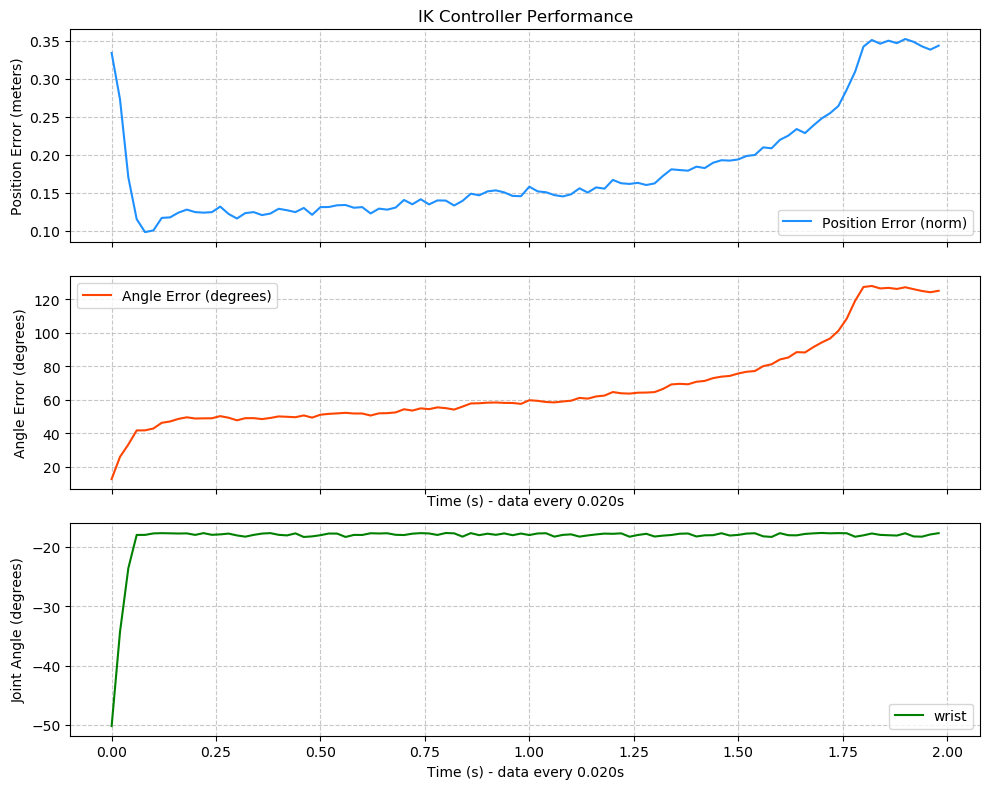

In [6]:
import matplotlib.pyplot as plt
actuator_indices_in_ctrl = np.arange(3, 3 + 9) # ctrl[3] から ctrl[11] まで

# qvel_indices_for_arm_dof: 上記のアクチュエータが制御するqvel内のDoFのインデックス。
# !!!警告!!!: このマッピングはロボットモデルに強く依存します。
# 以下の仮定は、実際のモデルでは正しくない可能性が高いです。
# 必ずご自身のモデルのXML定義（<actuator>タグのjointやtendon属性、
# <joint>タグのdofadrなど）を確認し、正確なマッピングを設定してください。
# 例として、ctrl[3:12]がqvel[3:12]を直接制御すると仮定します。
qvel_indices_for_arm_dof = np.arange(3, 3 + 9) 

if len(actuator_indices_in_ctrl) != len(qvel_indices_for_arm_dof):
    raise ValueError(
        f"Mismatch in length: actuator_indices_in_ctrl ({len(actuator_indices_in_ctrl)}) "
        f"and qvel_indices_for_arm_dof ({len(qvel_indices_for_arm_dof)}) must be the same."
    )
if len(actuator_indices_in_ctrl) == 0:
    raise ValueError("No actuators specified for control.")


env = MyRobotEnv(array=np.array([0,0,0, 0, -1, 0, -1, 0, -1, 0,0,0]))

ee_site_name = "ee_site"  # モデル内のEEサイト名
ee_site_id = mujoco.mj_name2id(env.model, mujoco.mjtObj.mjOBJ_SITE, ee_site_name)
if ee_site_id == -1:
    raise ValueError(f"EE site '{ee_site_name}' not found in the model.")
ee_body_id = env.model.site_bodyid[ee_site_id]

# IK制御パラメータ (タスクスペース用)
Kp_pos_ik = 130.0       # 位置制御Pゲイン
Kd_pos_ik = 10.0        # 位置制御Dゲイン
Kp_ori_ik = 170.0       # 姿勢制御Pゲイン
Kd_ori_ik = 10.0        # 姿勢制御Dゲイン
lambda_dls = 0.1       # DLSのダンピング係数
max_joint_vel_ik = 3.0  # IKが計算する目標関節速度のクリッピング値

# 関節トルク制御用PDゲイン (ジョイントスペース用)
Kp_joint_torque = 100.0  # 関節Pゲイン (目標速度誤差に対して)
Kd_joint_torque = 1.0   # 関節Dゲイン (現在速度に対して、ダンピング)
# Kp_joint_torque を 1.0 にし、Kd_joint_torque を調整すると、
# 以前の `torque = qvel_target - Kd_damping * qvel_current` の形式に近くなります。

# --- 目標位置と目標姿勢 (ワールド座標系) ---
target_ee_position = np.array([-0.9, 0.2, 0.1]) 
rad=np.radians(-180.0)
c=np.cos(rad)
s=np.sin(rad)
target_ee_orientation = np.array([ # 例: EEのZ軸がワールドの-Y軸、Y軸が-X軸、X軸が-Z軸
    [c, 0.0, s], 
    [0.0, 1.0,  0.0], 
    [-s, 0.0,  c]   
])

print(f"Target EE Position: {target_ee_position}")
print(f"Target EE Orientation Matrix:\n{target_ee_orientation}")
print(f"Controlling arm actuators at ctrl indices: {actuator_indices_in_ctrl}")
print(f"Assuming these control qvel DoFs at indices: {qvel_indices_for_arm_dof}")


env.reset()
mujoco.mj_forward(env.model, env.data) # 初期位置でのキネマティクス計算
print(f"Initial EE position: {env.data.site_xpos[ee_site_id]}")

num_steps = 2000
plot_time_steps = []
plot_position_errors = []
plot_angle_errors_deg = []
rendered_frames = [] # レンダリングフレーム保存用
data_collection_interval = 20
plot_selected_wrist_joint_angle_deg = []
for i in range(num_steps):
    # 1. IK計算でアームの目標関節「速度」を取得
    target_arm_joint_velocities = calculate_ik_target_velocities_wdls(
        env.model, env.data,
        target_ee_position, target_ee_orientation,
        ee_site_id, ee_body_id,
        qvel_indices_for_arm_dof, # qvel内のアームDoFインデックス
        np.array([7, 8]),
        100000.0,
        Kp_pos_ik, Kd_pos_ik, Kp_ori_ik, Kd_ori_ik, lambda_dls,
        max_joint_velocity=max_joint_vel_ik
    )
    
    # 2. 現在のアーム関節速度を取得
    current_arm_joint_velocities = env.data.qvel[qvel_indices_for_arm_dof]

    # 3. 目標関節速度と現在関節速度から「トルク」を計算 (PD制御)
    velocity_error = target_arm_joint_velocities - current_arm_joint_velocities
    # トルク = Kp_joint * (目標速度 - 現在速度) - Kd_joint * 現在速度
    torques_arm = Kp_joint_torque * velocity_error - Kd_joint_torque * current_arm_joint_velocities
    
    # (オプション) 計算されたトルクに制限をかける場合
    # max_allowable_torque = 50.0 # 例: Nm
    # torques_arm = np.clip(torques_arm, -max_allowable_torque, max_allowable_torque)

    # 4. 環境を1ステップ進める (計算されたトルクを入力)
    env.step(torques_arm)

    # 描画と情報表示
    if i % 20 == 0: # ステップごとに表示量を調整
        current_pos_ee = env.data.site_xpos[ee_site_id]
        pos_error_norm_ee = np.linalg.norm(target_ee_position - current_pos_ee)
        current_ee_orientation_matrix = env.data.site_xmat[ee_site_id].reshape(3, 3)
        print(f"Step {i:04d} | Pos Error: {pos_error_norm_ee:.4f}")
        print(f"  Current EE Orientation Matrix (Step {i:04d}):\n{current_ee_orientation_matrix}")
        
        diff_rot_mat = target_ee_orientation @ current_ee_orientation_matrix.T
        angle_error_rad = np.arccos(np.clip((np.trace(diff_rot_mat) - 1) / 2.0, -1.0, 1.0))
        print(f"  Approx. Angle Error: {np.degrees(angle_error_rad):.2f} deg")
        plot_time_steps.append(i * env.model.opt.timestep) # シミュレーション時間
        plot_position_errors.append(pos_error_norm_ee)
        plot_angle_errors_deg.append(np.degrees(angle_error_rad))
        joint_angle_rad = env.data.qpos[8]
        plot_selected_wrist_joint_angle_deg.append(np.degrees(joint_angle_rad))
        frame = env.render() # オフスクリーンレンダリング
        rendered_frames.append(frame)

        if pos_error_norm_ee < 0.005: # 収束判定 (必要に応じて姿勢誤差も追加)
            print(f"Target position potentially reached at step {i}.")
            # break # 収束したらループを抜ける

print("Simulation finished.")
final_pos_ee = env.data.site_xpos[ee_site_id]
print(f"Final EE position: {final_pos_ee}")
print(f"Position error: {np.linalg.norm(target_ee_position - final_pos_ee):.4f}")
if plot_time_steps: # データが収集されていればプロット
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True) # 2つのサブプロット、X軸共有

    # 位置誤差のプロット
    axs[0].plot(plot_time_steps, plot_position_errors, label='Position Error (norm)', color='dodgerblue')
    axs[0].set_ylabel('Position Error (meters)')
    axs[0].set_title('IK Controller Performance')
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.7)

    # 角度誤差のプロット
    axs[1].plot(plot_time_steps, plot_angle_errors_deg, label='Angle Error (degrees)', color='orangered')
    axs[1].set_xlabel(f'Time (s) - data every {data_collection_interval*env.model.opt.timestep:.3f}s')
    axs[1].set_ylabel('Angle Error (degrees)')
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.7)
    axs[2].plot(plot_time_steps, plot_selected_wrist_joint_angle_deg, label="wrist", color='green')
    axs[2].set_ylabel('Joint Angle (degrees)')
    axs[2].legend()
    axs[2].grid(True, linestyle='--', alpha=0.7)
    axs[2].set_xlabel(f'Time (s) - data every {data_collection_interval*env.model.opt.timestep:.3f}s')
    fig.tight_layout() # サブプロット間のスペースを調整
    plt.show()
else:
    print("No data collected for plotting.")
render(rendered_frames)